Checking the runtime type

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Installing necessary packages

In [ ]:
pip install mesa

In [ ]:
pip install rasterio

In [ ]:
pip install xlsxwriter

In [ ]:
pip install lhsmdu

In [ ]:
pip install tqdm

Importing necessary Modules and libraries

In [ ]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid, MultiGrid

from mesa.datacollection import DataCollector
import rasterio
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import numpy as np
import math
import random
import xlsxwriter

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

from mesa.visualization.modules import ChartModule

import scipy
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import multiprocessing as mp
import os
import lhsmdu
from tqdm import tqdm

Importing spatial data

In [ ]:
""" Importing spatial data """

Pop_dens=rasterio.open('/content/rec_pop_dens.asc')
Residential_places=rasterio.open('/content/resid_places_boolean.asc')
Educational_places=rasterio.open('/content/educ_places_boolean.asc')
Work_places=rasterio.open('/content/work_places_boolean.asc')
Other_places=rasterio.open('/content/other_places_boolean.asc')

Pop_dens_arr_diff_Coor = Pop_dens.read(1)
Residential_places_arr_diff_Coor = Residential_places.read(1)
Educational_places_arr_diff_Coor = Educational_places.read(1)
Work_places_arr_diff_Coor = Work_places.read(1)
Other_places_arr_diff_Coor = Other_places.read(1)

print(Pop_dens_arr_diff_Coor.shape)
Rows_num = Pop_dens_arr_diff_Coor.shape[0]
Cols_num = Pop_dens_arr_diff_Coor.shape[1]

print('row is: ', Rows_num)
print('col is: ', Cols_num)

Infection_transmission_arr = np.zeros((Cols_num, Rows_num)) #for storing the total number of infection-transmission in each cell


(239, 382)
row is:  239
col is:  382


Coordinate conversion

In [ ]:
""" The origin [0, 0] [height or row or x,width or column or y] of the data is left top as like the numpy array"""
"Cells with no-value gets -9999 in Python"

"""
Transformation of the coordinate system of imported data into Grid's coordinate system
All the imported data have the same size of row and column
imported data are indexed by [x, y], where [0, 0] is assumed to be the top-left and [row-1, column-1] is the bottom-right.
Grid cells are indexed by [X, Y], where [0, 0] is assumed to be the bottom-left and [height-1, width-1] is the top-right.

coordinate of imported data if is [x,y] and the coordinate system of grid is [X, Y], the following relationship exist between two coordinate systems:

X = y
Y = (row - 1) - x

also

x = (row - 1) - Y
y = X
"""

y = 0

while y < Cols_num:
    
    x = 0
    while x < Rows_num:
        if Pop_dens_arr_diff_Coor[x,y] < 0:
          Pop_dens_arr_diff_Coor[x,y] = 0

        if Residential_places_arr_diff_Coor[x,y] < 0:
          Residential_places_arr_diff_Coor[x,y]= 0

        if Educational_places_arr_diff_Coor[x,y] < 0:
          Educational_places_arr_diff_Coor[x,y] = 0
        
        if Work_places_arr_diff_Coor[x,y]<0:
          Work_places_arr_diff_Coor[x,y]=0
        
        if Other_places_arr_diff_Coor[x,y]<0:
          Other_places_arr_diff_Coor[x,y]=0

        x += 1
        
    y += 1

Pop_dens_arr = np.zeros((Cols_num, Rows_num), dtype = float)
Residential_places_arr = np.zeros((Cols_num, Rows_num), dtype = float)
Educational_places_arr = np.zeros((Cols_num, Rows_num), dtype = float)
Work_places_arr = np.zeros((Cols_num, Rows_num), dtype = float)
Other_places_arr = np.zeros((Cols_num, Rows_num), dtype = float)


X = 0

while X < Cols_num:
    
    Y = 0
    while Y < Rows_num:
        Pop_dens_arr[X, Y] = Pop_dens_arr_diff_Coor[Rows_num - 1 - Y, X]
        Residential_places_arr[X, Y] = Residential_places_arr_diff_Coor[Rows_num - 1 - Y, X]
        Educational_places_arr[X, Y] = Educational_places_arr_diff_Coor[Rows_num - 1 - Y, X]
        Work_places_arr[X, Y] = Work_places_arr_diff_Coor[Rows_num - 1 - Y, X]
        Other_places_arr[X, Y] = Other_places_arr_diff_Coor[Rows_num - 1 - Y, X]
        Y += 1
        
    X += 1

User-defined and interventions related Parameters

In [ ]:
""" User-defined parameters """
Number_of_days= 35 #int
Percentage_of_student_people_15_to_29 = 0.70 #float
Percentage_of_employed_people_15_and_over = 0.6519 #float
Number_of_exposed_people_at_the_beginning_of_the_simulation= [] #int
Number_of_infected_people_at_the_beginning_of_the_simulation= [] #int

""" Interventions related parameters """
Self_isolation_upon_symptoms_intervention = True #bool(True/False)
Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms = [] #float
Reduction_in_humans_movement_intervention = True #bool(True/False)
Percentage_of_reduction_in_humans_movements_to_public_places = 0.33 #float
Percentage_of_reduction_in_humans_movements_to_workplaces = 0.18 #float

Some functions to report the number of agents in each status

In [ ]:
def N_Sus_Agents(model):
    NS = model.number_of_susceptible_people
    return NS

def N_Exp_Agents(model):
    NE = model.number_of_exposed_people
    return NE

def N_Inf_Agents(model):
    NI = model.number_of_infected_people
    return NI

def N_Hos_Agents(model):
    NH = model.number_of_hospitalized_people
    return NH

def N_Rec_Agents(model):
    NR = model.number_of_recovered_people
    return NR

def N_Dead_Agents(model):
    ND = model.number_of_dead_people
    return ND

Defining two main classes of the agent-based modeling in Mesa: Model and Agent

In [ ]:
class Covid_Model(Model):

    def __init__(self, N = 18950, height=382, width=239): #constructor function of Covid_model class for instantiating an object
        #defining some attributes and initializing them
        self.height = height
        self.width = width
        self.number_of_agents = 18950
        
        self.Number_of_Age_4 = 1099
        self.Number_of_Age_9 = 1005
        self.Number_of_Age_14 = 853
        self.Number_of_Age_19 = 910
        self.Number_of_Age_29 = 2975
        self.Number_of_Age_39 = 3070
        self.Number_of_Age_49 = 2482
        self.Number_of_Age_59 = 2482
        self.Number_of_Age_69 = 1933
        self.Number_of_Age_70 = 2141

        self.Number_of_dead_people_so_far = 0
        
        self.number_of_susceptible_people = 18950
        self.number_of_exposed_people = 0
        self.number_of_infected_people = 0
        self.number_of_hospitalized_people = 0
        self.number_of_recovered_people = 0
        self.number_of_dead_people = 0
        
        self.number_of_newly_infected = 0
        self.number_of_total_newly_infected = 0
        self.Num_H_agents_in_each_HouseN=[]

        self.household_size_of_infected_agents = []
        self.age_of_infected_agents = []
        self.student_of_infected_agents = []
        self.employed_of_infected_agents = []

        self.first_week_infected_cases = []
        self.second_week_infected_cases = []
        self.third_week_infected_cases = []
        self.forth_week_infected_cases = []
        self.fifth_week_infected_cases = []
        
        self.schedule=RandomActivation(self) #adjusting a schedule to the model
        self.grid = MultiGrid(height, width, torus=False) #arranging a grid for the model
        
        #Calling several methods of Covid_Model class
        self.create_human_agents()
        self.distribution_of_human_agents()
        self.assign_jobs_to_Human_agents()
        self.initializing_exposed_and_infected_people_at_the_beginning()
        self.apply_intervention()

        
        self.running = True
        
        model_reporters={
            "number_of_susceptible_people": N_Sus_Agents,
            "number_of_exposed_people": N_Exp_Agents,
            "number_of_infectious_people": N_Inf_Agents,
            "number_of_hospitalized_people": N_Hos_Agents,
            "number_of_recovered_people": N_Rec_Agents,
            "number_of_dead_people": N_Dead_Agents,
              }
        
        self.datacollector = DataCollector(model_reporters)
        
                        
    def create_human_agents(self): #Body of of the create_human_agents for creating human agents based on the Human_agents class defined in the following
        ID_Uni = 0
        
        for i_4 in range(self.Number_of_Age_4):
            ID_Uni += 1
            a_4=Human_agents(ID_Uni, 4, 0.35, 0.456, 0.533, 0.001, 0.33, self)
            self.schedule.add(a_4)

        for i_9 in range(self.Number_of_Age_9):
            ID_Uni += 1
            a_9=Human_agents(ID_Uni, 9, 0.35, 0.456, 0.533, 0.001, 0.33, self)
            self.schedule.add(a_9)

        for i_14 in range(self.Number_of_Age_14):
            ID_Uni += 1
            a_14=Human_agents(ID_Uni, 14, 0.69, 0.412, 0.569, 0.006, 0.25, self)
            self.schedule.add(a_14)

        for i_19 in range(self.Number_of_Age_19):
            ID_Uni += 1
            a_19=Human_agents(ID_Uni, 19, 0.69, 0.412, 0.569, 0.006, 0.25, self)
            self.schedule.add(a_19)

        for i_29 in range(self.Number_of_Age_29):
            ID_Uni += 1
            a_29=Human_agents(ID_Uni, 29, 1.03, 0.370, 0.597, 0.015, 0.5, self)
            self.schedule.add(a_29)

        for i_39 in range(self.Number_of_Age_39):
            ID_Uni += 1
            a_39=Human_agents(ID_Uni, 39, 1.03, 0.332, 0.614, 0.069, 0.5, self)
            self.schedule.add(a_39)

        for i_49 in range(self.Number_of_Age_49):
            ID_Uni += 1
            a_49=Human_agents(ID_Uni, 49, 1.03, 0.296, 0.616, 0.219, 0.5, self)
            self.schedule.add(a_49)

        for i_59 in range(self.Number_of_Age_59):
            ID_Uni += 1
            a_59=Human_agents(ID_Uni, 59, 1.03, 0.265, 0.602, 0.279, 0.69, self)
            self.schedule.add(a_59)

        for i_69 in range(self.Number_of_Age_69):
            ID_Uni += 1
            a_69=Human_agents(ID_Uni, 69, 1.27, 0.238, 0.571, 0.370, 0.65, self)
            self.schedule.add(a_69)

        for i_70 in range(self.Number_of_Age_70):
            ID_Uni += 1
            a_70=Human_agents(ID_Uni, 70, 1.52, 0.214, 0.523, 0.391, 0.88, self)
            self.schedule.add(a_70)

    def distribution_of_human_agents(self): # method for distributing human agents in the environemnt

        list_of_households = [3426, 2593, 1186, 975, 576]
        House_N = 1
        
        for iiii in range(len(list_of_households)):

            qqq = 0
            
            while qqq < list_of_households[iiii]:
                
                ff = 0
                for H_agentss in self.schedule.agent_buffer(shuffled=True):
                    if ff != (iiii + 1):
                        if (H_agentss.assigned_HN == False):
                            H_agentss.Household_number = House_N
                            H_agentss.assigned_HN = True
                            ff += 1
                    else:
                        break


                self.Num_H_agents_in_each_HouseN.append(iiii + 1)
                House_N += 1
                qqq += 1
        ############################################
        print("The Overall number of household is: ", House_N - 1)

        Resid_Cells_indices = np.argwhere(Residential_places_arr == 1)
        ################################################################     1
        POP_Cells_indices_1 = np.argwhere(Pop_dens_arr == 1)

        coord_1= np.empty((0, 2))
        
        if (len(Resid_Cells_indices)) > (len(POP_Cells_indices_1)):

            for jJ in range(len(POP_Cells_indices_1)):
                for iI in range(len(Resid_Cells_indices)):
                    cC, dD = POP_Cells_indices_1[jJ, :]
                    eE, fF = Resid_Cells_indices[iI, :]
                    if cC == eE and dD == fF:
                        coord_1 = np.vstack((coord_1, np.array([cC, dD]).reshape(1,-1)))                    
                    else:
                        continue
                    
        else:
            for jJ in range(len(Resid_Cells_indices)):
                for iI in range(len(POP_Cells_indices_1)):
                    wW, tT = Resid_Cells_indices[jJ,:]
                    rR, vV = POP_Cells_indices_1[iI,:]
                    if wW == rR and tT == vV:
                        coord_1 = np.vstack((coord_1, np.array([wW, tT]).reshape(1,-1)))
                    else:
                        continue
        ################################################################     2
        POP_Cells_indices_2 = np.argwhere(Pop_dens_arr == 2)

        coord_2= np.empty((0, 2))
        
        if (len(Resid_Cells_indices)) > (len(POP_Cells_indices_2)):

            for jJ in range(len(POP_Cells_indices_2)):
                for iI in range(len(Resid_Cells_indices)):
                    cC, dD = POP_Cells_indices_2[jJ, :]
                    eE, fF = Resid_Cells_indices[iI, :]
                    if cC == eE and dD == fF:
                        coord_2 = np.vstack((coord_2, np.array([cC, dD]).reshape(1,-1)))                    
                    else:
                        continue
                    
        else:
            for jJ in range(len(Resid_Cells_indices)):
                for iI in range(len(POP_Cells_indices_2)):
                    wW, tT = Resid_Cells_indices[jJ,:]
                    rR, vV = POP_Cells_indices_2[iI,:]
                    if wW == rR and tT == vV:
                        coord_2 = np.vstack((coord_2, np.array([wW, tT]).reshape(1,-1)))
                    else:
                        continue
        ################################################################     3
        POP_Cells_indices_3 = np.argwhere(Pop_dens_arr == 3)

        coord_3= np.empty((0, 2))
        
        if (len(Resid_Cells_indices)) > (len(POP_Cells_indices_3)):

            for jJ in range(len(POP_Cells_indices_3)):
                for iI in range(len(Resid_Cells_indices)):
                    cC, dD = POP_Cells_indices_3[jJ, :]
                    eE, fF = Resid_Cells_indices[iI, :]
                    if cC == eE and dD == fF:
                        coord_3 = np.vstack((coord_3, np.array([cC, dD]).reshape(1,-1)))                    
                    else:
                        continue
                    
        else:
            for jJ in range(len(Resid_Cells_indices)):
                for iI in range(len(POP_Cells_indices_3)):
                    wW, tT = Resid_Cells_indices[jJ,:]
                    rR, vV = POP_Cells_indices_3[iI,:]
                    if wW == rR and tT == vV:
                        coord_3 = np.vstack((coord_3, np.array([wW, tT]).reshape(1,-1)))
                    else:
                        continue
        ################################################################     4
        POP_Cells_indices_4 = np.argwhere(Pop_dens_arr == 4)

        coord_4= np.empty((0, 2))
        
        if (len(Resid_Cells_indices)) > (len(POP_Cells_indices_4)):

            for jJ in range(len(POP_Cells_indices_4)):
                for iI in range(len(Resid_Cells_indices)):
                    cC, dD = POP_Cells_indices_4[jJ, :]
                    eE, fF = Resid_Cells_indices[iI, :]
                    if cC == eE and dD == fF:
                        coord_4 = np.vstack((coord_4, np.array([cC, dD]).reshape(1,-1)))                    
                    else:
                        continue
                    
        else:
            for jJ in range(len(Resid_Cells_indices)):
                for iI in range(len(POP_Cells_indices_4)):
                    wW, tT = Resid_Cells_indices[jJ,:]
                    rR, vV = POP_Cells_indices_4[iI,:]
                    if wW == rR and tT == vV:
                        coord_4 = np.vstack((coord_4, np.array([wW, tT]).reshape(1,-1)))
                    else:
                        continue

        ################################################################     5
        POP_Cells_indices_5 = np.argwhere(Pop_dens_arr == 5)

        coord_5= np.empty((0, 2))
        
        if (len(Resid_Cells_indices)) > (len(POP_Cells_indices_5)):

            for jJ in range(len(POP_Cells_indices_5)):
                for iI in range(len(Resid_Cells_indices)):
                    cC, dD = POP_Cells_indices_5[jJ, :]
                    eE, fF = Resid_Cells_indices[iI, :]
                    if cC == eE and dD == fF:
                        coord_5 = np.vstack((coord_5, np.array([cC, dD]).reshape(1,-1)))                    
                    else:
                        continue
                    
        else:
            for jJ in range(len(Resid_Cells_indices)):
                for iI in range(len(POP_Cells_indices_5)):
                    wW, tT = Resid_Cells_indices[jJ,:]
                    rR, vV = POP_Cells_indices_5[iI,:]
                    if wW == rR and tT == vV:
                        coord_5 = np.vstack((coord_5, np.array([wW, tT]).reshape(1,-1)))
                    else:
                        continue

        #Desinging and considering the Roulette wheel method in the human agents distribution procedure
        Roul_itter = 1
        Reg_sel = 0
        
        while Roul_itter <= (House_N - 1):
            Rn= 100 * np.random.rand()

            if Rn < 6.67:
                Reg_sel = 1            
                Ran_Choice = np.random.randint(0, len(coord_1))
                X_CORD, Y_CORD = coord_1[Ran_Choice]
                X_CORD = int(X_CORD)
                Y_CORD = int(Y_CORD)
                
            elif (Rn >= 6.67 and Rn < 20):
                Reg_sel = 2
                Ran_Choice = np.random.randint(0, len(coord_2))
                X_CORD, Y_CORD = coord_2[Ran_Choice]
                X_CORD = int(X_CORD)
                Y_CORD = int(Y_CORD)
                
            elif (Rn >= 20 and Rn < 40):
                Reg_sel = 3
                Ran_Choice = np.random.randint(0, len(coord_3))
                X_CORD, Y_CORD = coord_3[Ran_Choice]
                X_CORD = int(X_CORD)
                Y_CORD = int(Y_CORD)
                
            elif (Rn >= 40 and Rn < 66.67):
                Reg_sel = 4
                Ran_Choice = np.random.randint(0, len(coord_4))
                X_CORD, Y_CORD = coord_4[Ran_Choice]
                X_CORD = int(X_CORD)
                Y_CORD = int(Y_CORD)
                
            else: #(Rn >= 66.67 and Rn < 100)
                Reg_sel = 5
                Ran_Choice = np.random.randint(0, len(coord_5))
                X_CORD, Y_CORD = coord_5[Ran_Choice]
                X_CORD = int(X_CORD)
                Y_CORD = int(Y_CORD)            
            
            iitt = 0

            ppPP = Pop_dens_arr[X_CORD, Y_CORD]
            rrRR = Residential_places_arr[X_CORD, Y_CORD]

            NNnn = self.Num_H_agents_in_each_HouseN[Roul_itter - 1]
            
            if (ppPP == Reg_sel and rrRR == 1):
                
                for all_human_agents in self.schedule.agents:
                    if iitt != NNnn:
                        if (all_human_agents.located == False and all_human_agents.Household_number == Roul_itter):
                            self.grid.place_agent(all_human_agents, (X_CORD, Y_CORD))
                            all_human_agents.home_x = X_CORD
                            all_human_agents.home_y = Y_CORD
                            all_human_agents.cur_x = X_CORD
                            all_human_agents.cur_y = Y_CORD
                            all_human_agents.work_x = X_CORD
                            all_human_agents.work_y = Y_CORD
                            all_human_agents.located = True
                            iitt += 1
                    else:
                        break
            else:
                print("The chosen coordinates do not match with the intention of the designer!")
            
            Roul_itter += 1

    # defining a method for assigning the jobs to human agents based their ages
    def assign_jobs_to_Human_agents(self):
      
        Num_of_people_4_to_14 = self.Number_of_Age_4 + self.Number_of_Age_9 + self.Number_of_Age_14
        Num_of_people_15_to_29 = self.Number_of_Age_19 + self.Number_of_Age_29
        
        Num_of_students_15_to_29 = int(Percentage_of_student_people_15_to_29 * Num_of_people_15_to_29)

        Edu_Cells_indices = np.argwhere(Educational_places_arr == 1)
        

        aaa_1 = 0
        for hum_A in self.schedule.agents:
            if aaa_1 != Num_of_people_4_to_14:
                Rn_Edu_cell = np.random.randint(0, len(Edu_Cells_indices))
                XX_CORD, YY_CORD = Edu_Cells_indices[Rn_Edu_cell]
                if (hum_A.student == False and (hum_A.age == 4 or hum_A.age == 9 or hum_A.age == 14)):
                    hum_A.student = True
                    hum_A.work_x = XX_CORD
                    hum_A.work_y = YY_CORD
                    aaa_1 += 1
            else:
                break

        #########      
        aaa_2 = 0
        for hum_A2 in self.schedule.agents:
            if aaa_2 != Num_of_students_15_to_29:
                Rn_Edu_cell2 = np.random.randint(0, len(Edu_Cells_indices))
                XX_CORD_2, YY_CORD_2 = Edu_Cells_indices[Rn_Edu_cell2]
                
                if (hum_A2.student == False and (hum_A2.age >= 19)):
                    hum_A2.student = True
                    hum_A2.work_x = XX_CORD_2
                    hum_A2.work_y = YY_CORD_2
                    aaa_2 += 1
            else:
                break
        ########################
        Num_of_people_15_and_over = self.Number_of_Age_19 + self.Number_of_Age_29 + self.Number_of_Age_39 + self.Number_of_Age_49 + self.Number_of_Age_59 + self.Number_of_Age_69 + self.Number_of_Age_70
     
        Work_Cells_indices = np.argwhere(Work_places_arr == 1)  
        
        Num_of_people_15_and_over_employed = int(Percentage_of_employed_people_15_and_over * Num_of_people_15_and_over)    
                
        aaa_4 = 0
        for hum_A4 in self.schedule.agents:
            if aaa_4 != Num_of_people_15_and_over_employed:
                Rn_Work_cell2 = np.random.randint(0, len(Work_Cells_indices))
                XX_CORD_4, YY_CORD_4 = Work_Cells_indices[Rn_Work_cell2]
                
                if (hum_A4.student == False and hum_A4.employed == False and (hum_A4.age >= 19)):
                    hum_A4.employed = True
                    hum_A4.work_x = XX_CORD_4
                    hum_A4.work_y = YY_CORD_4
                    aaa_4 += 1
            else:
                break

    ############################################################
    #initializing the exposed and infectious human agents at the beginning of the simulation

    def initializing_exposed_and_infected_people_at_the_beginning(self): 

        if Number_of_exposed_people_at_the_beginning_of_the_simulation > 0:
            
            NEP = 0               
            for Sus_Human in self.schedule.agent_buffer(shuffled=True):
                if NEP != Number_of_exposed_people_at_the_beginning_of_the_simulation:
                    
                    if Sus_Human.susceptible == True:
                        print('Age: ', Sus_Human.age)
                        Sus_Human.susceptible=False
                        self.number_of_susceptible_people -= 1
                        Sus_Human.exposed=True
                        self.number_of_exposed_people += 1
                        Sus_Human.infected = False
                        Sus_Human.recovered = False
                        Sus_Human.hospitalized = False
                        Sus_Human.probability_of_getting_inpatient=False
                        Sus_Human.probability_of_getting_recovered=False
                        Sus_Human.investigation_of_rec_or_hosp=False
                        Sus_Human.investigation_of_rec_or_death=False
                        Sus_Human.probability_of_getting_recovered_from_hosp=False
                        Sus_Human.probability_of_dieing=False
                        Sus_Human.dead=False
                        Sus_Human.people_tick_number=0
                        Sus_Human.ticks_of_getting_exposed=0
                        
                        ran_Num = np.random.rand()

                        if ran_Num < Sus_Human.fraction_of_infected_Asym:
                            Sus_Human.exposed_Asym = True
                            Sus_Human.A_d = 0.33

                        elif (ran_Num >= Sus_Human.fraction_of_infected_Asym and ran_Num < (Sus_Human.fraction_of_infected_Asym + Sus_Human.fraction_of_infected_mild_symp)):
                            Sus_Human.exposed_Mild = True
                            Sus_Human.A_d = 0.72

                        elif ran_Num >= (Sus_Human.fraction_of_infected_Asym + Sus_Human.fraction_of_infected_mild_symp):
                            Sus_Human.exposed_Severe = True
                            Sus_Human.A_d = 1
                            
                        NEP += 1
                else:
                    break
                    
                
        if Number_of_infected_people_at_the_beginning_of_the_simulation > 0:
            
            NIP = 0
            for Exp_Human in self.schedule.agent_buffer(shuffled=True):
                if NIP != Number_of_infected_people_at_the_beginning_of_the_simulation:              
                    if Exp_Human.susceptible == True:
                        print('Age: ', Exp_Human.age)
                        Exp_Human.susceptible=False
                        self.number_of_susceptible_people -= 1
                        Exp_Human.exposed=False
                        Exp_Human.infected = True
                        self.number_of_infected_people += 1
                        Exp_Human.recovered = False
                        Exp_Human.hospitalized = False
                        Exp_Human.probability_of_getting_inpatient=False
                        Exp_Human.probability_of_getting_recovered=False
                        Exp_Human.investigation_of_rec_or_hosp=False
                        Exp_Human.investigation_of_rec_or_death=False
                        Exp_Human.probability_of_getting_recovered_from_hosp=False
                        Exp_Human.probability_of_dieing=False
                        Exp_Human.dead=False
                        Exp_Human.people_tick_number=0

                        ranInf = np.random.rand()

                        if ranInf < (Exp_Human.fraction_of_infected_Asym + Exp_Human.fraction_of_infected_mild_symp):
                            Exp_Human.infected_Mild = True
                            Exp_Human.A_d = 0.72
                        else:
                            Exp_Human.infected_Severe = True
                            Exp_Human.A_d = 1
                            
                        NIP += 1

                else:
                    break

        ################################################################
    # defining apply_intervention method for applying the interventions in the model
    def apply_intervention(self):

        for A_H_Ag in self.schedule.agents:

            if A_H_Ag.age > 4 and A_H_Ag.age <= 69 and A_H_Ag.employed == True:
                A_H_Ag.Staying_duration_at_workplace = 8
                Ran_Num_to_select_1 = np.random.randint(0,3)
                A_H_Ag.Staying_duration_at_home = Ran_Num_to_select_1 + 3
                A_H_Ag.staying_duration_at_public_places = 8 - A_H_Ag.Staying_duration_at_home

            if A_H_Ag.age > 4 and A_H_Ag.age <= 69 and A_H_Ag.student == True:
                '''education closures intervention was employed in this period.'''
                A_H_Ag.Staying_duration_at_workplace = 0
                Ran_Num_to_select_1 = np.random.randint(0,3)
                A_H_Ag.Staying_duration_at_home = Ran_Num_to_select_1 + 3
                A_H_Ag.staying_duration_at_public_places = 8 - A_H_Ag.Staying_duration_at_home
                A_H_Ag.Staying_duration_at_home += 8


            if A_H_Ag.age > 29 and A_H_Ag.age <= 69 and A_H_Ag.student == False and A_H_Ag.employed == False:
                A_H_Ag.Staying_duration_at_workplace = 0
                Ran_Num_to_select_2 = np.random.randint(0,5)
                A_H_Ag.Staying_duration_at_home = Ran_Num_to_select_2 + 6
                A_H_Ag.staying_duration_at_public_places = 16 - A_H_Ag.Staying_duration_at_home
                

            if A_H_Ag.age > 69:
                A_H_Ag.Staying_duration_at_workplace = 0
                Ran_Num_to_select_3 = np.random.randint(0,3)
                A_H_Ag.Staying_duration_at_home = Ran_Num_to_select_3 + 11
                A_H_Ag.staying_duration_at_public_places = 16 - A_H_Ag.Staying_duration_at_home

            if Reduction_in_humans_movement_intervention == True:
                if A_H_Ag.age > 4 and A_H_Ag.reduction_of_movement_intervention == False:
                    A_H_Ag.reduction_hour_of_people_movements_to_public_places = round(Percentage_of_reduction_in_humans_movements_to_public_places * A_H_Ag.staying_duration_at_public_places)
                    A_H_Ag.reduction_hour_of_people_movements_to_workplaces = round(Percentage_of_reduction_in_humans_movements_to_workplaces * A_H_Ag.Staying_duration_at_workplace)

                    if A_H_Ag.staying_duration_at_public_places >= A_H_Ag.reduction_hour_of_people_movements_to_public_places:
                        A_H_Ag.staying_duration_at_public_places -= A_H_Ag.reduction_hour_of_people_movements_to_public_places
                        A_H_Ag.Staying_duration_at_home += A_H_Ag.reduction_hour_of_people_movements_to_public_places

                    if A_H_Ag.Staying_duration_at_workplace >= A_H_Ag.reduction_hour_of_people_movements_to_workplaces:
                        A_H_Ag.Staying_duration_at_workplace -= A_H_Ag.reduction_hour_of_people_movements_to_workplaces
                        A_H_Ag.Staying_duration_at_home += A_H_Ag.reduction_hour_of_people_movements_to_workplaces

                    A_H_Ag.reduction_of_movement_intervention = True

            else:
                A_H_Ag.reduction_of_movement_intervention = False

    #defining a method to evaluate the transtion of statues in human agents
    def function_of_transition_between_statuses(self):
        
        Ticks = self.schedule.time
        print()
        print('Ticks', Ticks)
        print()

        
        for HHuum in self.schedule.agents:
                
            if HHuum.exposed == True:
                
                if HHuum.exposed_Asym == True:        
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_a_rec):
                        HHuum.recovered = True
                        HHuum.exposed = False
                        self.number_of_exposed_people -= 1
                        self.number_of_recovered_people += 1                    
                        HHuum.people_tick_number = Ticks                       
                        
                elif HHuum.exposed_Mild == True:
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_symp):
                        HHuum.infected = True
                        HHuum.exposed = False
                        self.number_of_exposed_people -= 1
                        self.number_of_infected_people += 1                       
                        HHuum.infected_Mild = True
                        HHuum.infected_Severe = False
                        HHuum.people_tick_number = Ticks
                        
                elif HHuum.exposed_Severe == True:
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_symp):
                        HHuum.infected = True
                        HHuum.exposed = False
                        self.number_of_exposed_people -= 1
                        self.number_of_infected_people += 1 
                        HHuum.infected_Mild = False
                        HHuum.infected_Severe = True
                        HHuum.people_tick_number = Ticks

            ##############################

            if (Self_isolation_upon_symptoms_intervention == True):

                if (HHuum.infected == True and HHuum.isolation_evaluation == False):

                    rannnn = np.random.rand()
                    if rannnn < Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms:
                        HHuum.self_isolation_observing_intervention = True
                    HHuum.isolation_evaluation=True
                        
                    
                
            if HHuum.infected == True:
                
                if HHuum.infected_Mild == True:
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_rec):
                        HHuum.infected = False
                        HHuum.recovered = True
                        self.number_of_infected_people -= 1
                        self.number_of_recovered_people += 1
                        HHuum.people_tick_number = Ticks

                if (HHuum.infected_Severe == True and HHuum.investigation_of_rec_or_hosp == False):
                    rraann = np.random.rand()

                    if rraann < HHuum.fraction_of_infected_hosp:
                        HHuum.probability_of_getting_inpatient = True
                        HHuum.probability_of_getting_recovered = False
                    else:
                        HHuum.probability_of_getting_inpatient = False
                        HHuum.probability_of_getting_recovered = True

                    HHuum.investigation_of_rec_or_hos = True
                        


                if (HHuum.infected_Severe == True and HHuum.probability_of_getting_inpatient == True):
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_hosp):
                        HHuum.infected = False
                        HHuum.hospitalized = True
                        self.number_of_infected_people -= 1
                        self.number_of_hospitalized_people += 1
                        HHuum.people_tick_number = Ticks

                if (HHuum.infected_Severe == True and HHuum.probability_of_getting_recovered == True):
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_rec):
                        HHuum.infected = False
                        HHuum.recovered = True
                        self.number_of_infected_people -= 1
                        self.number_of_recovered_people += 1
                        HHuum.people_tick_number = Ticks

            ###################################
            if HHuum.hospitalized == True:

                if HHuum.investigation_of_rec_or_death == False:
                    rrrr= np.random.rand()

                    if rrrr < HHuum.fraction_of_death:
                        HHuum.probability_of_dieing = True
                        HHuum.probability_of_getting_recovered_from_hosp = False
                    else:
                        HHuum.probability_of_dieing = False
                        HHuum.probability_of_getting_recovered_from_hosp = True

                    HHuum.investigation_of_rec_or_death = True
                
                if HHuum.probability_of_dieing == True:
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_death):
                        HHuum.dead = True
                        self.Number_of_dead_people_so_far += 1
                        HHuum.hospitalized = False
                        self.number_of_hospitalized_people -= 1
                        self.number_of_dead_people += 1
                        HHuum.people_tick_number = Ticks

                if HHuum.probability_of_getting_recovered_from_hosp == True:
                    if ((Ticks) - (HHuum.people_tick_number) > HHuum.Gamma_hosp_rec):
                        HHuum.recovered = True
                        HHuum.hospitalized = False
                        self.number_of_recovered_people += 1
                        self.number_of_hospitalized_people -= 1
                        HHuum.people_tick_number = Ticks

                ########################################################
    def model_step(self):
        self.number_of_newly_infected = 0
        self.datacollector.collect(self)
        Model_results = self.datacollector.get_model_vars_dataframe()
        #Model_results.plot()
        self.schedule.step()
        self.function_of_transition_between_statuses()        
        
    def run_model(self, stps):
        row_index = 2
        row_index_2 = 2

        workbook = xlsxwriter.Workbook("Daily results of the Model.xlsx")
        worksheet = workbook.add_worksheet("Results")

        worksheet.write('A1', 'Step')
        worksheet.write('B1', 'Susceptible people')
        worksheet.write('C1', 'Exposed people')
        worksheet.write('D1', 'Infectious people')
        worksheet.write('E1', 'Hospitalized people')
        worksheet.write('F1', 'Recovered people')
        worksheet.write('G1', 'Dead people')
        worksheet.write('H1', 'Newly infected people')

        workbook_2 = xlsxwriter.Workbook("Weekly results of the Model.xlsx")
        worksheet_2 = workbook_2.add_worksheet("Results")

        worksheet_2.write('A1', 'Step')
        worksheet_2.write('B1', 'Newly infected people')

        NNI = 0
        
        for jj in range(stps):
            self.model_step()
            worksheet.write('A' + str(row_index), jj + 1)
            worksheet.write('B' + str(row_index), self.number_of_susceptible_people)
            worksheet.write('C' + str(row_index), self.number_of_exposed_people)
            worksheet.write('D' + str(row_index), self.number_of_infected_people)
            worksheet.write('E' + str(row_index), self.number_of_hospitalized_people)
            worksheet.write('F' + str(row_index), self.number_of_recovered_people)
            worksheet.write('G' + str(row_index), self.number_of_dead_people)
            worksheet.write('H' + str(row_index), self.number_of_newly_infected)
            
            NNI += self.number_of_newly_infected
            
            if ((jj + 1) % 7 == 0 ):

                if (jj + 1) == 7:
                    self.first_week_infected_cases = NNI
                if (jj + 1) == 14:
                    self.second_week_infected_cases = NNI
                if (jj + 1) == 21:
                    self.third_week_infected_cases = NNI
                if (jj + 1) == 28:
                    self.forth_week_infected_cases = NNI
                if (jj + 1) == 35:
                    self.fifth_week_infected_cases = NNI
        
                worksheet_2.write('A' + str(row_index_2), jj + 1)
                worksheet_2.write('B' + str(row_index_2), NNI)
                NNI = 0
                row_index_2 += 1
            
            row_index += 1
        
        workbook.close()
        workbook_2.close()
        #####################################
        
        workbook_agent = xlsxwriter.Workbook("infectious_agents_results.xlsx")
        worksheet_agent = workbook_agent.add_worksheet("Infectious agents details")

        worksheet_agent.write('A1', 'Household size')
        worksheet_agent.write('B1', 'Age')
        worksheet_agent.write('C1', 'Student')
        worksheet_agent.write('D1', 'Employed')

        for ppp in range(len(self.household_size_of_infected_agents)):
            ddd = ppp + 1
            worksheet_agent.write(ddd, 0, self.household_size_of_infected_agents[ppp])
            worksheet_agent.write(ddd, 1, self.age_of_infected_agents[ppp])
            worksheet_agent.write(ddd, 2, self.student_of_infected_agents[ppp])
            worksheet_agent.write(ddd, 3, self.employed_of_infected_agents[ppp])
                        
        workbook_agent.close()
 

In [ ]:
class Human_agents(Agent):
    def __init__(self, unique_id, Age, RSTI, F_Asym, F_Mild_Symp, F_Inf_Hosp, F_Death, model): #Human_agents constructor function 
        #defining some attributes for human agents and initializing them
        super().__init__(unique_id, model)

        self.ID = unique_id
        self.age = Age
        self.Relative_susceptibility_to_infection = RSTI
        self.fraction_of_infected_Asym = F_Asym
        self.fraction_of_infected_mild_symp = F_Mild_Symp
        self.fraction_of_infected_hosp = F_Inf_Hosp
        self.fraction_of_death = F_Death

        self.assigned_HN = False
        self.Household_number = 0
        
        self.susceptible=True
        self.exposed=False
        self.infected=False
        self.recovered=False
        self.hospitalized=False
        self.dead=False

        self.home_x=0
        self.home_y=0
        self.cur_x = 0
        self.cur_y = 0
        
        self.Gamma_symp = np.random.gamma(shape=4.03, scale=1.345)
        self.Gamma_rec = np.random.gamma(shape=5.76, scale=2.0833)
        self.Gamma_hosp_rec = np.random.gamma(shape=1, scale=8.7489)
        self.Gamma_death = np.random.gamma(shape=1.7838, scale=6.5833)
        self.Gamma_a_rec = np.random.gamma(shape=9, scale=1.6667)
        self.Gamma_hosp = np.random.gamma(shape=1.4977, scale=3.4317)

        self.R0 = np.random.normal(loc=4.5, scale=0.5625)
        if self.R0 < 3.66:
            self.R0=3.66
        elif self.R0 > 5.58:
            self.R0=5.58

        self.work_x=0
        self.work_y=0

        self.located = False

        self.student=False
        self.employed=False

        self.exposed_Asym = False
        self.exposed_Mild = False
        self.exposed_Severe = False

        self.infected_Mild = False
        self.infected_Severe = False

        self.probability_of_getting_inpatient = False
        self.probability_of_getting_recovered = False

        self.investigation_of_rec_or_hosp = False
        self.investigation_of_rec_or_death = False

        self.probability_of_getting_recovered_from_hosp = False
        self.probability_of_dieing = False

        self.people_tick_number = 0
        self.ticks_of_getting_exposed=0
        
        self.A_d = 0

        self.number_of_people_infected_by_myself_so_far = 0

        self.reduction_of_movement_intervention = False
        self.self_isolation_observing_intervention = False

        self.Staying_duration_at_home = 0
        self.staying_duration_at_public_places = 0
        self.Staying_duration_at_workplace = 0
        
        self.reduction_hour_of_people_movements_to_public_places = 0
        self.reduction_hour_of_people_movements_to_workplaces = 0

        self.isolation_evaluation = False
        
        if self.age == 4:
            self.Daily_number_of_interactions = np.random.normal(loc=10.21, scale=7.65)
            
        if self.age == 9:
            self.Daily_number_of_interactions = np.random.normal(loc=14.81, scale=10.09)
            
        if self.age == 14:
            self.Daily_number_of_interactions = np.random.normal(loc=18.22, scale=12.27)

        if self.age == 19:
            self.Daily_number_of_interactions = np.random.normal(loc=17.58, scale=12.03)

        if self.age == 29:
            self.Daily_number_of_interactions = np.random.normal(loc=13.57, scale=10.6)

        if self.age == 39:
            self.Daily_number_of_interactions = np.random.normal(loc=14.14, scale=10.15)
            
        if self.age == 49:
            self.Daily_number_of_interactions = np.random.normal(loc=13.83, scale=10.86)

        if self.age == 59:
            self.Daily_number_of_interactions = np.random.normal(loc=12.30, scale=10.23)
            
        if self.age == 69:
            self.Daily_number_of_interactions = np.random.normal(loc=9.21, scale=7.96)
            
        if self.age == 70:
            self.Daily_number_of_interactions = np.random.normal(loc=6.89, scale=5.83)

    #evaluating the transmission possibility of infection between human agents  
    def transmission_evaluation(self):
        global Infection_transmission_arr
        if self.self_isolation_observing_intervention == False:
            if self.infected == True:
                if self.number_of_people_infected_by_myself_so_far < math.ceil(self.R0):
                    xXX = self.cur_x
                    yYY = self.cur_y
                                           
                    for hum in self.model.schedule.agent_buffer(shuffled=True):
                        x_agent = hum.cur_x
                        y_agent = hum.cur_y
                        agent_HN = hum.Household_number
                        
                        if (xXX == self.home_x and yYY == self.home_y):
                            HhNn = self.Household_number
                            n_value=2
                            Ad_local = self.A_d
                            R0_for_calcu = self.R0
                            ttt=self.ticks_of_getting_exposed
                            
                            if (x_agent == xXX and y_agent == yYY and agent_HN == HhNn):

                                if (hum.susceptible == True):
                                    RRAA = np.random.rand()
                                    
                                    sigmaa=2.14
                                    muu=5.5
                                    sss = (-1.0 / (2 * sigmaa * sigmaa))
                                    vvv=self.model.schedule.time
                                    integration_section = integrate.quad(lambda x: ((1 / (sigmaa * math.sqrt(2*math.pi)))* math.exp(sss*(x-muu)*(x-muu))), ttt, vvv)[0]
                                    Zarib = ((R0_for_calcu * hum.Relative_susceptibility_to_infection * n_value * Ad_local)/(hum.Daily_number_of_interactions))
                                    landaaa= Zarib * integration_section     
                                    try:
                                        if (landaaa > 20):
                                            Prob_inf = 1 #1 - np.exp(-1 * landaaa)
                                            
                                        elif (landaaa < -20):
                                            Prob_inf = 0 #1 - np.exp(-1 * landaaa)
                                            
                                        else:
                                            Prob_inf = 1 - np.exp(-1 * landaaa)
                                            
                                    except OverflowError:
                                        Prob_inf = 1
                                        

                                    if RRAA < Prob_inf:
                                        hum.exposed=True
                                        hum.susceptible=False
                                        self.model.number_of_susceptible_people -= 1
                                        self.model.number_of_exposed_people += 1
                                        hum.ticks_of_getting_exposed = self.model.schedule.time
                                        hum.people_tick_number = self.model.schedule.time
                                        Infection_transmission_arr[x_agent, y_agent] += 1
                                        self.model.number_of_newly_infected += 1                        
                                        self.model.number_of_total_newly_infected += 1
                                        hs = self.model.Num_H_agents_in_each_HouseN[hum.Household_number - 1]
                                        self.model.household_size_of_infected_agents.append(hs)
                                        self.model.age_of_infected_agents.append(hum.age)
                                        self.model.student_of_infected_agents.append(hum.student)
                                        self.model.employed_of_infected_agents.append(hum.employed)

                                      
                                        Rn_Nmm = np.random.rand()

                                        if Rn_Nmm < hum.fraction_of_infected_Asym:
                                            hum.exposed_Asym = True
                                            hum.A_d = 0.33

                                        elif (Rn_Nmm >= hum.fraction_of_infected_Asym and Rn_Nmm < (hum.fraction_of_infected_Asym + hum.fraction_of_infected_mild_symp)):
                                            hum.exposed_Mild = True
                                            hum.A_d = 0.72

                                        elif Rn_Nmm >= (hum.fraction_of_infected_Asym + hum.fraction_of_infected_mild_symp):
                                            hum.exposed_Severe = True
                                            hum.A_d = 1


                                        self.number_of_people_infected_by_myself_so_far += 1
                                        break
                                    else:
                                        break                               
                            else:
                                continue
                        else:
                            HhNn = self.Household_number
                            n_value=1
                            Ad_local = self.A_d
                            R0_for_calcu = self.R0
                            ttt=self.ticks_of_getting_exposed
                            
                            if (x_agent == xXX and y_agent == yYY and agent_HN != HhNn):

                                if (hum.susceptible == True):
                                    RRAA = np.random.rand()
                                    
                                    sigmaa=2.14
                                    muu=5.5
                                    sss = (-1.0 / (2 * sigmaa * sigmaa))
                                    vvv=self.model.schedule.time
                                    integration_section = integrate.quad(lambda x: ((1 / (sigmaa * math.sqrt(2*math.pi)))* math.exp(sss*(x-muu)*(x-muu))), ttt, vvv)[0]
                                    Zarib = ((R0_for_calcu * hum.Relative_susceptibility_to_infection * n_value * Ad_local)/(hum.Daily_number_of_interactions))
                                    landaaa= Zarib * integration_section
                                    try:
                                        if (landaaa > 20):
                                            Prob_inf = 1 #1 - np.exp(-1 * landaaa)
                                            
                                        elif (landaaa < -20):
                                            Prob_inf = 0 #1 - np.exp(-1 * landaaa)
                                            
                                        else:
                                            Prob_inf = 1 - np.exp(-1 * landaaa)
                                            
                                    except OverflowError:
                                        Prob_inf = 1
                                        

                                    if RRAA < Prob_inf:                                       
                                        hum.exposed=True
                                        hum.susceptible=False
                                        self.model.number_of_susceptible_people -= 1
                                        self.model.number_of_exposed_people += 1
                                        hum.people_tick_number = self.model.schedule.time
                                        hum.ticks_of_getting_exposed = self.model.schedule.time
                                        Infection_transmission_arr[x_agent, y_agent] += 1
                                        self.model.number_of_newly_infected += 1                        
                                        self.model.number_of_total_newly_infected += 1
                                        hs = self.model.Num_H_agents_in_each_HouseN[hum.Household_number - 1]
                                        self.model.household_size_of_infected_agents.append(hs)
                                        self.model.age_of_infected_agents.append(hum.age)
                                        self.model.student_of_infected_agents.append(hum.student)
                                        self.model.employed_of_infected_agents.append(hum.employed)

                                      
                                        Rn_Nmm = np.random.rand()

                                        if Rn_Nmm < hum.fraction_of_infected_Asym:
                                            hum.exposed_Asym = True
                                            hum.A_d = 0.33

                                        elif (Rn_Nmm >= hum.fraction_of_infected_Asym and Rn_Nmm < (hum.fraction_of_infected_Asym + hum.fraction_of_infected_mild_symp)):
                                            hum.exposed_Mild = True
                                            hum.A_d = 0.72

                                        elif Rn_Nmm >= (hum.fraction_of_infected_Asym + hum.fraction_of_infected_mild_symp):
                                            hum.exposed_Severe = True
                                            hum.A_d = 1


                                        self.number_of_people_infected_by_myself_so_far += 1
                                        break
                                    else:
                                        break
                                
                            else:
                                continue
                            
                                                         
    ######################################################
    def step(self):
        # Each step has been considered a day in the real world.
        if self.Staying_duration_at_home > 0:
            
            for hhs in range(self.Staying_duration_at_home):
                #instead of two following lines we could use also this line: self.model.grid.place_agent(self, (self.home_x, self.home_y))
                self.cur_x = self.home_x
                self.cur_y = self.home_y
                self.transmission_evaluation()       
            
        if self.age > 4:
            
            if (self.Staying_duration_at_workplace > 0 and self.student == False):
                #instead of two following lines we could use also this line: self.model.grid.place_agent(self, (self.work_x, self.work_y))
                for ttt in range(self.Staying_duration_at_workplace):
                    self.cur_x = self.work_x
                    self.cur_y = self.work_y
                    self.transmission_evaluation()
            
            if self.staying_duration_at_public_places > 0:
                
                for ff in range(self.staying_duration_at_public_places):
                    Other_Cells_indices = np.argwhere(Other_places_arr == 1)
                        
                    Rn_Other_cell = np.random.randint(0, len(Other_Cells_indices))
                    X_COO, Y_COO = Other_Cells_indices[Rn_Other_cell]

                    otOT = Other_places_arr[X_COO, Y_COO]
                    
                    if otOT == 1:
                        #instead of two following lines we could use also this line: self.model.grid.place_agent(self, (X_COO, Y_COO))
                        self.cur_x = X_COO
                        self.cur_y = Y_COO
                        self.transmission_evaluation()

Calibration process

In [ ]:
total_confirmed_cases_in_5_weeks = round((315+385+482+549+479) / 100) #five weeks infected cases
        
# Required to set before running waves:
UU1 = np.array([])
UU2 = np.array([])
UU3 = np.array([])
UU4 = np.array([])
UU5 = np.array([])

def sim_func(x): #to run the simulation
    global Number_of_exposed_people_at_the_beginning_of_the_simulation
    Number_of_exposed_people_at_the_beginning_of_the_simulation= x[0,0]
    
    global Number_of_infected_people_at_the_beginning_of_the_simulation
    Number_of_infected_people_at_the_beginning_of_the_simulation= x[0,1]
    
    global Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms
    Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms = x[0,2]
    
    MModel = Covid_Model(N=18950, height=382, width=239)
    
    global Number_of_days
    MModel.run_model(Number_of_days)
    
    Tot_New_inf = MModel.number_of_total_newly_infected
    global UU1
    global UU2
    global UU3
    global UU4
    global UU5

    UU1 = np.append(UU1, MModel.first_week_infected_cases)
    UU2 = np.append(UU2, MModel.second_week_infected_cases)
    UU3 = np.append(UU3, MModel.third_week_infected_cases)
    UU4 = np.append(UU4, MModel.forth_week_infected_cases)
    UU5 = np.append(UU5, MModel.fifth_week_infected_cases)

    return Tot_New_inf

def error_func(x): # to calculate the error between simulation and observation
    return abs(total_confirmed_cases_in_5_weeks - x)

# Optional to set:
obs_var = 0  # the uncertainty in the observation (as variance)
k = 30  # total ensembles run for each input, change as desired
ensemble_samples = 4  # total samples used to average ensemble variance


# Initially uknown and automatically calculated:
ens_var = 0  # ensemble variance
model_disc = 0  # model discrepancy
total_uncertainty = 0  # sum of all uncertainties


def variety_func(X):
    """ Run the model with a set of parameters X, each run once.
    This will need to be overridden if using a netlogo model. """
    pool = mp.Pool(mp.cpu_count())
    Y = pool.map(sim_func, [X[row] for row in range(len(X))])
    pool.close()
    pool.join()
    return Y


def run_k_times(x):
    # Run the parameters x a total of k times.
    global UU1
    global UU2
    global UU3
    global UU4
    global UU5
    global Number_of_exposed_people_at_the_beginning_of_the_simulation   
    global Number_of_infected_people_at_the_beginning_of_the_simulation   
    global Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms

    T = []
    for _ in tqdm(range(k), desc = "Run-K-times: "):
      V = sim_func(x)
      T.append(V)
    
    UU1= UU1.reshape(-1,1)
    UU2= UU2.reshape(-1,1)
    UU3= UU3.reshape(-1,1)
    UU4= UU4.reshape(-1,1)
    UU5= UU5.reshape(-1,1)

    P1 = np.mean(UU1, axis =0)
    P2 = np.mean(UU2, axis =0)
    P3 = np.mean(UU3, axis =0)
    P4 = np.mean(UU4, axis =0)
    P5 = np.mean(UU5, axis =0)

    W1 = ((P1 - 3)**2)/3
    W2 = ((P2 - 4)**2)/4
    W3 = ((P3 - 5)**2)/5
    W4 = ((P4 - 5)**2)/5
    W5 = ((P5 - 5)**2)/5

    chi_square_value = W1 + W2 + W3 + W4 + W5
    
    if chi_square_value < 9.488:
        print("The model meets the validation criterion!")
        print("Number_of_exposed_people_at_the_beginning_of_the_simulation = ", Number_of_exposed_people_at_the_beginning_of_the_simulation)
        print("Number_of_infected_people_at_the_beginning_of_the_simulation = ", Number_of_infected_people_at_the_beginning_of_the_simulation)
        print("Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms = ", Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms)
        print("chi_square_value = ", chi_square_value)
    else:
        print("Number_of_exposed_people_at_the_beginning_of_the_simulation = ", Number_of_exposed_people_at_the_beginning_of_the_simulation)
        print("Number_of_infected_people_at_the_beginning_of_the_simulation = ", Number_of_infected_people_at_the_beginning_of_the_simulation)
        print("Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms = ", Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms)
        print("chi_square_value = ", chi_square_value)
    
    UU1 = np.array([])
    UU2 = np.array([])
    UU3 = np.array([])
    UU4 = np.array([])
    UU5 = np.array([])
    return T


def ensemble_func(X, k):
    """ Run the model each parameter set in X a total of k times.
    This will need to be overridden if using a netlogo model. """
    pool = mp.Pool(mp.cpu_count())
    Y = pool.map_async(run_k_times, [X[row] for row in range(len(X))]).get()
    pool.close()
    pool.join()
    return Y


def recalculate_uncertainties(X):
    """ Calculate the average uncertainties across inputs X.
    Each value x in X represents a different input parameter to test.
    Returns: (average ensemble variance across X,
              average model discrepancy across X)
    """
    vars = []
    discrepancies = []

    all_X_run_results = ensemble_func(X, k)
    for run_results in all_X_run_results:
        errors = [error_func(r) for r in run_results]
        vars.append(np.var(errors, ddof=1))
    
    errors_2 = []
    all_X_run_results_2 = variety_func(X)
    for run_results_2 in all_X_run_results_2:
      errors_2.append(error_func(run_results_2))
    
    discrepancies = np.var(errors_2, ddof=1)

    globals()['ens_var'] = np.mean(vars)
    globals()['model_disc'] = discrepancies
    globals()['total_uncertainty'] = ens_var + obs_var + model_disc

    print("Model_discrepency = ", model_disc)
    print("Ensemble_variance = ", ens_var)

def _implaus(x):
    """ Calculate the implausibility of the parameter x."""
    num = error_func(x)  # no emulator, only simulator
    denom = np.sqrt(total_uncertainty)  # only ensemble uncertainty
    return num / denom


def is_all_plausible(prev_plaus_space, new_plaus_space):
    """ Stopping criteria. Test if no new implausible space was found."""
    # If they're the same size, they must be the same
    return len(prev_plaus_space) == len(new_plaus_space)


def is_v_ens_x_small(new_plaus_space):
    """ Stopping criteria.
        Test if the variance of plausible space is less than model variance.
    """
    # add other uncertainties to the right side as they become included
    return np.var(new_plaus_space) < (total_uncertainty)


def wave(plaus_space):
    """ Run a wave of history matching.
    plaus_space is (for now) a list of discrete points.
    Returns the new plausible points found in plaus_space
    plus the implausibility scores.
    """
    # Get the new ensemble variance using a selection of three inputs from X,
    # where these inputs are evenly spread across the plausible space.
    # TODO: an optimised design, such as LHS, would be preferred.
    print('Getting ensemble variance...')
    global ensemble_samples
    test_space = [(plaus_space[i]) for i in range(0,len(plaus_space),math.ceil(len(plaus_space)/ensemble_samples))]
    recalculate_uncertainties(test_space)
    new_plaus_space = []
    print('Getting implausibility scores...')
    Y = variety_func(plaus_space)
    implaus_scores = [_implaus(y) for y in Y]
    for i in range(len(plaus_space)):
        if implaus_scores[i] < 3:
            new_plaus_space.append(plaus_space[i])
    return total_uncertainty, new_plaus_space, implaus_scores

Run_cri = True

while Run_cri == True:

    Sam = lhsmdu.sample(3,20)

    NewRange_Exp = 9
    NewRange_Inf = 9

    NewValue_Exp = np.round(Sam[0,:] * NewRange_Exp) + 1
    NewValue_Exp = NewValue_Exp.reshape(-1,1)
    print("NewValue_Exp = ", NewValue_Exp)
    NewValue_Inf = np.round(Sam[1,:] * NewRange_Inf) + 1
    NewValue_Inf = NewValue_Inf.reshape(-1,1)
    print("NewValue_Inf = ", NewValue_Inf)
    NewValue_Per = (Sam[2,:])
    NewValue_Per = NewValue_Per.reshape(-1,1)
    print("NewValue_Per = ", NewValue_Per)

    Con_1 = np.concatenate((NewValue_Exp,NewValue_Inf), axis=1)
    prev_plaus_space = np.concatenate((Con_1, NewValue_Per), axis = 1)

    total_uncertainty, new_plaus_space, implaus_scores = wave(prev_plaus_space)
    print("The wave function was done successfully!")
    if is_all_plausible(prev_plaus_space, new_plaus_space) == True or is_v_ens_x_small(new_plaus_space) == True:
        print("total_uncertainty = ", total_uncertainty)
        print("new_plaus_space = ", new_plaus_space)
        print("implaus_scores = ", implaus_scores)
        print("model_disc = ", model_disc)
        print("ens_var = ", ens_var)
        Run_cri = False
        break
    else:
        prev_plaus_space = new_plaus_space

Statuses plots

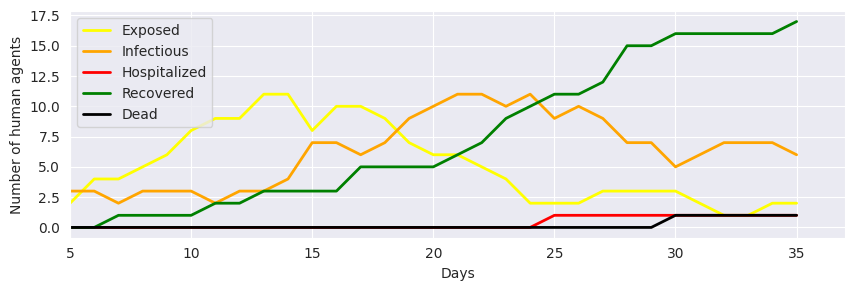

In [ ]:
Daily_res = '/content/Daily results of the Model.xlsx'
Daily_num= pd.read_excel(Daily_res)

step3 = Daily_num.iloc[:,0]
Exp3 = Daily_num.iloc[:,2]
Inf3 = Daily_num.iloc[:,3]
Hos3 = Daily_num.iloc[:,4]
Rec3 = Daily_num.iloc[:,5]
Dead3 = Daily_num.iloc[:,6]
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(10, 3), dpi=100)

plt.xlabel('Days')
plt.ylabel('Number of human agents')
plt.plot(step3, Exp3, 'yellow', linewidth=2, label = "Exposed")
plt.plot(step3, Inf3, 'orange', linewidth=2, label = "Infectious")
plt.plot(step3, Hos3, 'red', linewidth=2, label = "Hospitalized")
plt.plot(step3, Rec3, 'green', linewidth=2, label = "Recovered")
plt.plot(step3, Dead3, 'black', linewidth=2, label = "Dead")
plt.legend()
plt.xlim([5, 37])
plt.grid(True)

Running model after finding values for unknown parameters

In [ ]:
total_confirmed_cases_in_5_weeks = round((315+385+482+549+479) / 100) #five weeks infected cases
        
# Required to set before running waves:
UU1 = np.array([])
UU2 = np.array([])
UU3 = np.array([])
UU4 = np.array([])
UU5 = np.array([])

def sim_func(x): #to run the simulation
    global Number_of_exposed_people_at_the_beginning_of_the_simulation
    Number_of_exposed_people_at_the_beginning_of_the_simulation= x[0,0]
    
    global Number_of_infected_people_at_the_beginning_of_the_simulation
    Number_of_infected_people_at_the_beginning_of_the_simulation= x[0,1]
    
    global Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms
    Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms = x[0,2]
    
    MModel = Covid_Model(N=18950, height=382, width=239)
    
    global Number_of_days
    MModel.run_model(Number_of_days)
    
    print("First_week_infected_cases = ", MModel.first_week_infected_cases)
    print("Second_week_infected_cases = ", MModel.second_week_infected_cases)
    print("Third_week_infected_cases = ", MModel.third_week_infected_cases)
    print("Forth_week_infected_cases = ", MModel.forth_week_infected_cases)
    print("Fifth_week_infected_cases = ", MModel.fifth_week_infected_cases)

    Tot_New_inf = MModel.number_of_total_newly_infected
    global UU1
    global UU2
    global UU3
    global UU4
    global UU5

    UU1 = np.append(UU1, MModel.first_week_infected_cases)
    UU2 = np.append(UU2, MModel.second_week_infected_cases)
    UU3 = np.append(UU3, MModel.third_week_infected_cases)
    UU4 = np.append(UU4, MModel.forth_week_infected_cases)
    UU5 = np.append(UU5, MModel.fifth_week_infected_cases)

################################################################
Unknown_par = np.array([1,3,0.42]).reshape(1,-1) #setting the values found in calibration or any other values that are desired to run the model with

for it_num in tqdm(range(30), desc = 'Run: '):
    sim_func(Unknown_par)

# exporting the number of infection that happend in each cell during the simulation
infection_transmission_transformed_to_input_data_coordinate = np.zeros((Rows_num, Cols_num), dtype = float)


x = 0

while x < Rows_num:
    
    y = 0
    while y < Cols_num:
        infection_transmission_transformed_to_input_data_coordinate[x, y] = Infection_transmission_arr[y, Rows_num - 1 - x]
        y += 1
        
    x += 1

infection_transmission_locations = rasterio.open(
                                                 '/content/infection_transmission_total.asc',
                                                 'w',
                                                 driver='GTiff',
                                                 height=239,
                                                 width=382,
                                                 count=1,
                                                 dtype='float64',
                                                 crs='EPSG:4326',
                                                 transform = Pop_dens.transform,
                                                 nodata = 0                                         
                                                 )
infection_transmission_locations.write(infection_transmission_transformed_to_input_data_coordinate, 1)
infection_transmission_locations.close()

UU1= UU1.reshape(-1,1)
UU2= UU2.reshape(-1,1)
UU3= UU3.reshape(-1,1)
UU4= UU4.reshape(-1,1)
UU5= UU5.reshape(-1,1)

P1 = np.mean(UU1, axis =0)
P2 = np.mean(UU2, axis =0)
P3 = np.mean(UU3, axis =0)
P4 = np.mean(UU4, axis =0)
P5 = np.mean(UU5, axis =0)

W1 = ((P1 - 3)**2)/3
W2 = ((P2 - 4)**2)/4
W3 = ((P3 - 5)**2)/5
W4 = ((P4 - 5)**2)/5
W5 = ((P5 - 5)**2)/5

chi_square_value = W1 + W2 + W3 + W4 + W5

if chi_square_value < 9.488:
    print("The model meets the validation criterion!")
    print("Number_of_exposed_people_at_the_beginning_of_the_simulation = ", Number_of_exposed_people_at_the_beginning_of_the_simulation)
    print("Number_of_infected_people_at_the_beginning_of_the_simulation = ", Number_of_infected_people_at_the_beginning_of_the_simulation)
    print("Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms = ", Percentage_of_infected_people_who_isolate_themselves_upon_observing_symptoms)
    print("chi_square_value = ", chi_square_value)
else:
    print("chi_square_value = ", chi_square_value)